# <b>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</b>
## <b>3) Grid Search</b>  

___

## <b>Table of Content</b> <a id="toc_"></a>

* [Training Window Length](#trainwindow)  
* [Top-n Ports for Auto Defined Services](#topn)  
    * [Single Training](#topn:single)  
    * [incremental Training](#topn:incremental)  
* [k of k-NN Classifier](#knofknn)
* [Without Duplicates and Incremental Training](#duplicatesincremental)
* [Word2Vec Parameters](#word2vec)
* [Best Cases](#final)  

Notebook description

___
***Note:*** All the code and data we provide are the ones included in the paper. To speed up the notebook execution, by default we trim the files when reading them. Comments on how to run on complete files are provided in the notebook. Note that running the notebook with the complete dataset requires *a PC with significant amount of memory*. 

***Note:*** Be aware that these script require a large amount of time for training all models tested in the paper.

In [3]:
DEMONSTRATIVE = False

In [1]:
from config import *
from src.word2vec import Word2Vec
from src.preprocess import load_raw_data, filter_data
from src.preprocess import get_next_day, get_prev_day
from src.knnClassifier import *
from src.utils import *
from src.callbacks import *

from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances as distances
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler
plt.rcParams["font.family"] = "serif"

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

___
### <b>Prerequisites</b> <a name="trainwindow"></a>



In [3]:
# Load last day of traffic
raw_data = load_raw_data('20210331')
filtered = filter_data(raw_data, '20210331')

print(filtered.shape)
filtered.head(3)

(3403919, 6)


,ts,ip,port,proto,pck_len,pp
ts,,,,,,
2021-03-30 22:29:08.691001,2021-03-30 22:29:08.691001,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.691010,2021-03-30 22:29:08.691010,201.166.132.114,1433,tcp,66,1433/tcp
2021-03-30 22:29:08.811067,2021-03-30 22:29:08.811067,172.245.10.231,3699,tcp,60,3699/tcp


In [4]:
# Load the ground truth
gt = pd.read_csv(GT).drop(columns=['Unnamed: 0'])
ips = filtered.ip.unique()
# Get the lookup dataframe to retrieve
# the ground truth class of the last day senders
lookup = pd.DataFrame(ips, columns=['ip'])\
           .merge(gt, on='ip', how='left')\
           .fillna('unknown').replace({ 'criminalip':'unknown', 
                'adscore':'unknown', 'quadmetrics':'unknown', 
                'esrg_stanford':'unknown', 'netscout':'unknown'})

print(lookup.shape)
lookup.head(3)

(22399, 2)


,ip,class
0,201.166.132.114,unknown
1,172.245.10.231,unknown
2,119.237.180.88,unknown


___
### <b>Training Window Length</b> <a name="trainwindow"></a>



In [6]:
known_ips = set(lookup[lookup['class']!='unknown'].ip.unique())
if not DEMONSTRATIVE: tr_days = [1, 2, 3, 4, 5, 10, 20, 30]
else: tr_days = [1, 2, 3]
gs_train_window = []
for days in tr_days:
    day = '20210331'
    raws = []
    for d in range(days):
        _raw = load_raw_data(day)
        raws.append(_raw)
        day = get_prev_day(day)
    _raw = pd.concat(raws)
    # Apply the filter
    freqs = _raw.value_counts('ip')
    idx = freqs[freqs>=10].index
    _active = _raw[(_raw.ip.isin(known_ips)) & (_raw.ip.isin(idx))]
    # Get the coverage
    covered = _active.ip.unique().shape[0]
    coverage = covered*100/len(known_ips)
    gs_train_window.append((days, coverage))
gs_train_window = pd.DataFrame(gs_train_window, columns=['training_days', 'ip_set'])
gs_train_window.head()

,training_days,ip_set
0,1,32.582749
1,2,57.585825
2,3,69.595177


<Figure size 640x480 with 0 Axes>

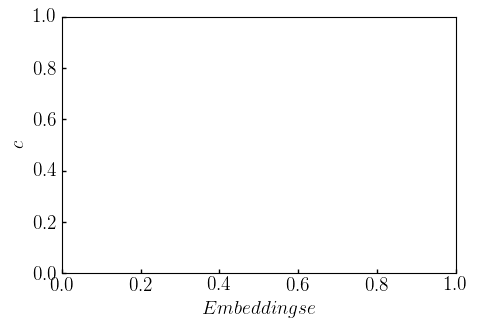

In [8]:
import fastplot

def custom_f(plt):
    plt.xlabel('$Embeddings e$')
    plt.ylabel('$c$')

%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: custom_f(plt),
                      figsize=(5, 3.5), fontsize=14, style='latex')
#if not DEMONSTRATIVE:
plot.savefig('reports/figures/tmp.pdf')

plot.show()

<Figure size 640x480 with 0 Axes>

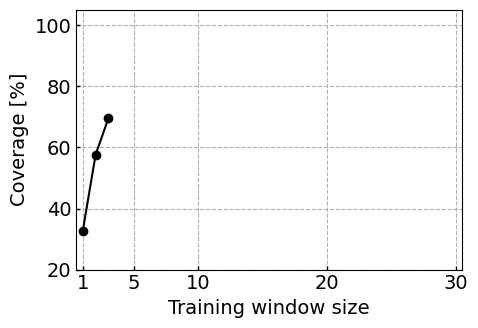

In [7]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plotTrainingWindow(plt, gs_train_window),
                      figsize=(5, 3.5), fontsize=14)
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/gs_training_window.pdf')

plot.show()

___
### <b>Top-n Ports for Auto Defined Services</b> <a name="topn"></a>



___
#### <b>Incremental Training</b> <a name="topn:incremental"></a>


In [13]:
avg_x, avg_y, perclass_x, perclass_y = ([] for i in range(4))
if not DEMONSTRATIVE: TOPN = [1, 3, 5, 10, 30, 40, 50, 60, 100, 
                              500, 1000 ,1500, 2500, 3000, 10000]
else: TOPN = [1, 3, 5, 10]
    
for TOP in TOPN:
    # Load the model and retrieve the embeddings
    model_path_name = f'gridsearch_incremental_ports_{TOP}'
    print(f'Loading {model_path_name}')
    w2v = Word2Vec(mname=f'{MODELS}/gridsearch/{model_path_name}')
    w2v.load_model()
    embeddings = w2v.get_embeddings(ips, lookup)
    # Run a 7-NN classifier and get the report
    print('Running the 7-NN classifier')
    knn = KnnClassifier(embeddings, 7)
    knn.fit_predict()
    knnlabels = lookup[lookup['class']!='unknown']['class'].unique()
    # Classification report
    report = knn.get_report(output_dict=True, labels=knnlabels)
    
    # Update lists for plot
    for k,v in report.items():
        if k == 'macro avg':
            avg_y.append(v['f1-score'])
            avg_x.append(TOP)
        if k not in ['micro avg', 'macro avg', 'weighted avg']:
            perclass_y.append(v['f1-score'])
            perclass_x.append(TOP)

Loading gridsearch_incremental_ports_1
Running the 7-NN classifier
Loading gridsearch_incremental_ports_3
Running the 7-NN classifier
Loading gridsearch_incremental_ports_5
Running the 7-NN classifier
Loading gridsearch_incremental_ports_10
Running the 7-NN classifier


<Figure size 640x480 with 0 Axes>

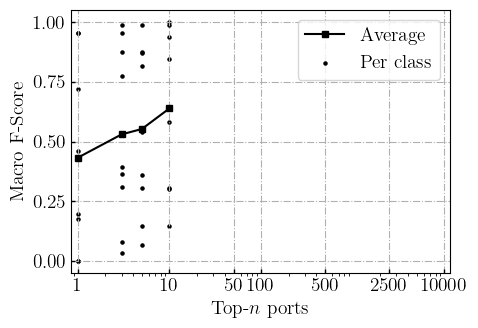

In [14]:
%matplotlib inline

plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plotTopN(plt, perclass_x, perclass_y, avg_x, avg_y),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/auto-defined-ports-incremental.pdf')
plot.show()

___
#### <b>Single Training</b> <a name="topn:single"></a>



In [15]:
avg_x, avg_y, perclass_x, perclass_y = ([] for i in range(4))
if not DEMONSTRATIVE: TOPN = [1, 3, 5, 10, 30, 40, 50, 60, 100, 
                              500, 1000 ,1500, 2500, 3000, 10000]
else: TOPN = [1, 3, 5, 10]
    
for TOP in TOPN:
    # Load the model and retrieve the embeddings
    model_path_name = f'gridsearch_single_ports_{TOP}'
    print(f'Loading {model_path_name}')
    w2v = Word2Vec(mname=f'{MODELS}/gridsearch/{model_path_name}')
    w2v.load_model()
    embeddings = w2v.get_embeddings(ips, lookup)
    # Run a 7-NN classifier and get the report
    print('Running the 7-NN classifier')
    knn = KnnClassifier(embeddings, 7)
    knn.fit_predict()
    knnlabels = lookup[lookup['class']!='unknown']['class'].unique()
    # Classification report
    report = knn.get_report(output_dict=True, labels=knnlabels)
    
    # Update lists for plot
    for k,v in report.items():
        if k == 'macro avg':
            avg_y.append(v['f1-score'])
            avg_x.append(TOP)
        if k not in ['micro avg', 'macro avg', 'weighted avg']:
            perclass_y.append(v['f1-score'])
            perclass_x.append(TOP)

Loading gridsearch_single_ports_1
Running the 7-NN classifier
Loading gridsearch_single_ports_3
Running the 7-NN classifier
Loading gridsearch_single_ports_5
Running the 7-NN classifier
Loading gridsearch_single_ports_10
Running the 7-NN classifier


<Figure size 640x480 with 0 Axes>

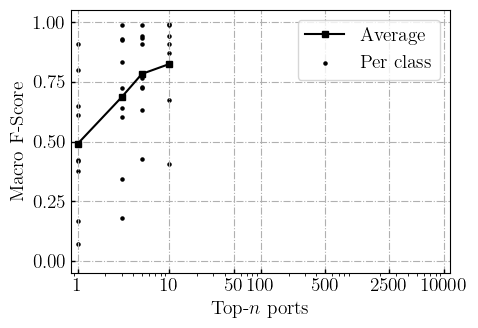

In [16]:
%matplotlib inline

plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plotTopN(plt, perclass_x, perclass_y, avg_x, avg_y),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/auto-defined-ports-single.pdf')
plot.show()

___
### <b>k of k-NN Classifier</b> <a name="knofknn"></a>



In [19]:
m1, m2, m3, m4 = ([] for _ in range(4))
if not DEMONSTRATIVE: x_ = np.arange(1, 40, 2)
else: x_ = np.arange(1, 6, 2)
#for method in ['dks', 'single', 'auto', 'hybrid']:
for method in ['dks', 'single', 'auto']:
    try:
        mname = f'gs_kofknn_incremental_{method}_new_True'
        print(f'Loading {mname}')
        w2v = Word2Vec(mname=mname)
        w2v.load_model()
    except:
        mname = f'{MODELS}/gridsearch/gs_kofknn_incremental_{method}'
        print(f'Loading {mname}')
        w2v = Word2Vec(mname=mname)
        w2v.load_model()
    embeddings = w2v.get_embeddings(ips, lookup)
    for kk in x_:
        knn = KnnClassifier(embeddings, kk)
        knn.fit_predict()
        knnlabels = lookup[lookup['class']!='unknown']['class'].unique()
        report = knn.get_report(output_dict=True, labels=knnlabels)
        f1 = report['macro avg']['f1-score']
        
        if method == 'dks': m1.append(f1)
        elif method == 'single': m2.append(f1)
        elif method == 'auto': m3.append(f1)
        elif method == 'hybrid': m4.append(f1)

Loading gs_kofknn_incremental_dks_new_True
Loading gs_kofknn_incremental_single_new_True
Loading /share/smartdata/huawei/darknet_graph/PaperExtension/models/gridsearch/gs_kofknn_incremental_single
Loading gs_kofknn_incremental_auto_new_True


In [10]:
def plotKofKnn(plt, x, y1, y2, y3):
    plt.plot(x, y1, marker='o', markersize=4, label='DKS')
    plt.plot(x, y2, marker='s', markersize=4, label='SS')
    plt.plot(x, y3, marker='^', markersize=4, label='AS')
    plt.xlabel('$k$')
    plt.ylabel('Avg. $k$-NN Macro F-Score')
    plt.xticks([1, 3, 5, 7, 17, 25, 35], [1, 3, 5, 7, 17, 25, 35])
    plt.xlim(0, 40)
    plt.ylim(0, 1)
    plt.grid(linestyle='-.')
    plt.legend(ncol=3)

<Figure size 640x480 with 0 Axes>

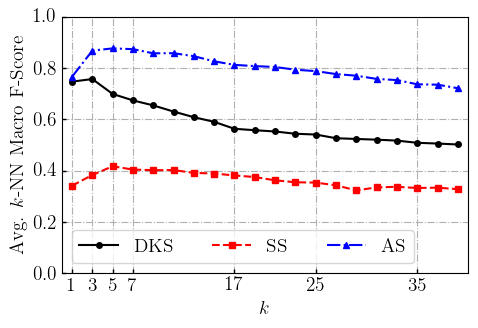

In [11]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plotKofKnn(plt, x_, m1, m2, m3),
                      cycler=cc, figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/knn_trend.pdf')
plot.show()

___
### <b>Without Duplicates and Incremental Training</b> <a name="duplicatesincremental"></a>



In [15]:
for with_ in [False, True]:
    for ss in ['auto', 'dks']:
        w2v = Word2Vec(mname=f'gs_kofknn_incremental_{ss}_new_{with_}')
        w2v.load_model()
        embeddings = w2v.get_embeddings(ips, lookup)

        knn = KnnClassifier(embeddings, 5)
        knn.fit_predict()
        knnlabels = lookup[lookup['class']!='unknown']['class'].unique()
        report = knn.get_report(output_dict=True, labels=knnlabels)
        print(with_, ss)
        print(report['macro avg'])
        print(report['weighted avg'])

False auto
{'precision': 0.9305002376300615, 'recall': 0.8265387472721962, 'f1-score': 0.8677954531816279, 'support': 8127}
{'precision': 0.9937912943396799, 'recall': 0.9714531807555064, 'f1-score': 0.9818836505984008, 'support': 8127}
False dks
{'precision': 0.8643757214785988, 'recall': 0.6207926817366176, 'f1-score': 0.6346314060411964, 'support': 8127}
{'precision': 0.9794279705597936, 'recall': 0.9389688692014273, 'f1-score': 0.9527963092331229, 'support': 8127}
True auto
{'precision': 0.9407388007601093, 'recall': 0.8311393172444773, 'f1-score': 0.8623290281006596, 'support': 8127}
{'precision': 0.9937295419772219, 'recall': 0.9697305278700628, 'f1-score': 0.9790341816345296, 'support': 8127}
True dks
{'precision': 0.8310548982267392, 'recall': 0.6936551505180648, 'f1-score': 0.7170578837298158, 'support': 8127}
{'precision': 0.9815272389741527, 'recall': 0.9413067552602437, 'f1-score': 0.9576525726768504, 'support': 8127}


___
### <b>Word2Vec Parameters</b> <a name="word2vec"></a>



In [2]:
service = 'as'

_heatmap = pd.DataFrame(get_heatmap_df(service, ips, lookup))

%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plotGridsearchFscore(plt, _heatmap.T),
                      figsize=(5, 3.5), fontsize=16, style='latex')
#if not DEMONSTRATIVE:
#    plot.savefig(f'report/figures/gs_{service}.pdf')
plot.show()

NameError: name 'get_heatmap_df' is not defined

<Figure size 640x480 with 0 Axes>

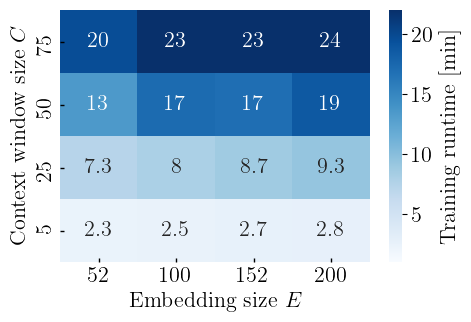

In [21]:
_heatmap = pd.DataFrame(extract_gridsearch_runtimes(service))

%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: plotGridsearchRuntimes(plt, _heatmap),
                      figsize=(5, 3.5), fontsize=16, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('gs_times_DK.pdf')
plot.show()

___
### <b>Best Cases</b> <a name="final"></a>



In [22]:
mlist = [('ss', 5, 52), ('dk', 5, 152),
         ('auto', 5, 200)]
snames = {'ss':'Single', 'dk':'Domain Knowledge Based',
          'auto':'Auto Defined', 'hybrid':'Hybrid'}
for service, c, e in mlist:
    model_path_name = f'model_gs_{service}_c{c}_e{e}'
    w2v = Word2Vec(mname=f'{MODELS}/gridsearch/{model_path_name}')
    w2v.load_model()
    embeddings = w2v.get_embeddings(ips, lookup)

    knn = KnnClassifier(embeddings, 5)
    knn.fit_predict()
    knnlabels = lookup[lookup['class']!='unknown']['class'].unique()
    report = knn.get_report(output_dict=True, labels=knnlabels)
    
    to_replace = {'mirai':'Mirai-like', 'censys':'Censys',
     'stretchoid': 'Stretchoid', 'internet-census':'Internet-census',
     'binaryedge':'Binaryedge', 'sharashka':'Sharashka', 'ipip':'Ipip',
     'shodan':'Shodan', 'engin-umich':'Engin-umich', 'weighted avg':'weighted avg',
     'macro avg':'macro avg', 'micro avg':'micro avg'}

    col_idx2 = ['Precision', 'Recall', 'F-Score', 'Support']
    temp = pd.DataFrame(report).T.sort_values('support', ascending=False)
    #temp.index = [v for k,v in to_replace.items()]
    #temp.columns = col_idx2

    print('====================================================')
    print(snames[service])
    print('====================================================')
    print(temp.round(2))
    print()

Single
                 precision  recall  f1-score  support
micro avg             0.99    0.95      0.97   8127.0
macro avg             0.90    0.79      0.80   8127.0
weighted avg          0.99    0.95      0.96   8127.0
mirai                 1.00    0.97      0.98   7351.0
censys                0.92    0.93      0.92    336.0
stretchoid            0.80    0.04      0.07    104.0
internet-census       0.97    0.92      0.95    103.0
binaryedge            0.99    0.97      0.98    101.0
sharashka             0.94    0.88      0.91     50.0
ipip                  0.55    0.76      0.64     49.0
shodan                0.93    0.61      0.74     23.0
engin-umich           1.00    1.00      1.00     10.0

Domain Knowledge Based
                 precision  recall  f1-score  support
micro avg             0.99    0.94      0.96   8127.0
macro avg             0.87    0.82      0.83   8127.0
weighted avg          0.99    0.94      0.96   8127.0
mirai                 1.00    0.95      0.98   7351

In [8]:
# Load the final model
model_path_name = f'word2vec_auto_c5_e200'
w2v = Word2Vec(mname=f'{MODELS}/word2vec/{model_path_name}')
w2v.load_model()
# Retrieve the embeddings
embeddings = w2v.get_embeddings(ips, lookup)

print(embeddings.shape)
embeddings.head(3)

(22399, 201)


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,class
ip,,,,,,,,,,,,,,,,,,,,,
201.166.132.114,-0.311996,-0.151880,-0.126155,-0.072640,-0.178640,0.024080,-0.022133,0.057160,-0.323721,0.022568,...,0.283371,0.126785,0.275466,0.114976,0.073976,-0.138251,0.262670,-0.148449,-0.197116,unknown
172.245.10.231,-1.256613,-1.317889,-0.910986,-0.773604,-1.041731,0.157510,-0.035242,-0.574435,-0.953921,-0.234043,...,0.120722,0.061658,0.289806,0.052150,0.272534,0.037336,0.426259,-0.294904,0.005054,unknown
119.237.180.88,-0.090121,-0.085896,0.007295,-0.115396,-0.096167,0.018933,-0.014268,0.004455,-0.023784,0.002346,...,0.032283,0.021382,0.159330,0.020799,0.031832,-0.078330,0.073449,0.004153,-0.060807,unknown


In [11]:
if not DEMONSTRATIVE:
    X = embeddings.drop(columns=['class'])
else:
    X = embeddings.iloc[:500].drop(columns=['class'])
dist = distances(X, X, metric='cosine')

tsne = TSNE(n_components=2, random_state=15, metric='precomputed').fit_transform(dist)
df = pd.DataFrame(tsne, columns=['x', 'y'])
if not DEMONSTRATIVE:
    df.to_csv(f'{DATASETS}/tsne.csv')

<Figure size 640x480 with 0 Axes>

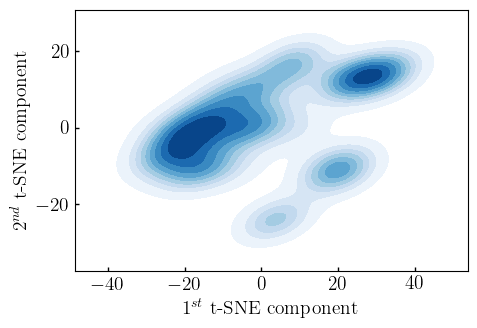

In [12]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: densityPlot(plt, df),
                      figsize=(5, 3.5), fontsize=14, style='latex')
if not DEMONSTRATIVE:
    plot.savefig('reports/figures/density_kde.pdf')
plot.show()